In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [101]:
temp = pd.read_csv('/content/drive/MyDrive/Forecasting/FRED-LTOTALNSA.csv', index_col='Date', parse_dates=True)
sales = temp[::-1]
sales

,Value
Date,
1976-01-01,864.600
1976-02-01,973.300
1976-03-01,1216.100
1976-04-01,1163.200
1976-05-01,1176.100
...,...
2021-09-01,1015.935
2021-10-01,1051.015
2021-11-01,1014.411


In [102]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 1976-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   553 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


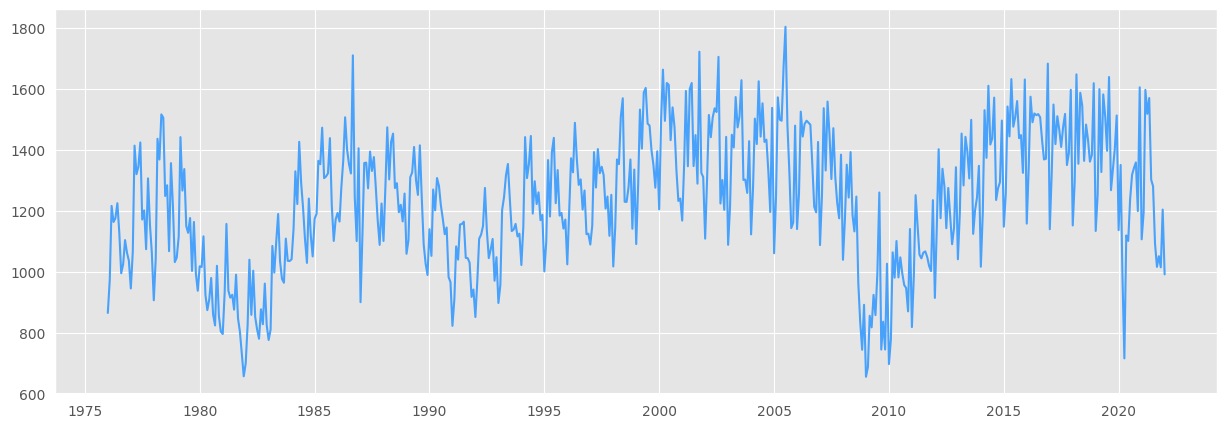

In [103]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(sales, c = '#48A1FA')
plt.show()

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x = sales, model = 'additive', period = 12)
trend = ss_decomposition.trend
seasonal = ss_decomposition.seasonal
residual = ss_decomposition.resid

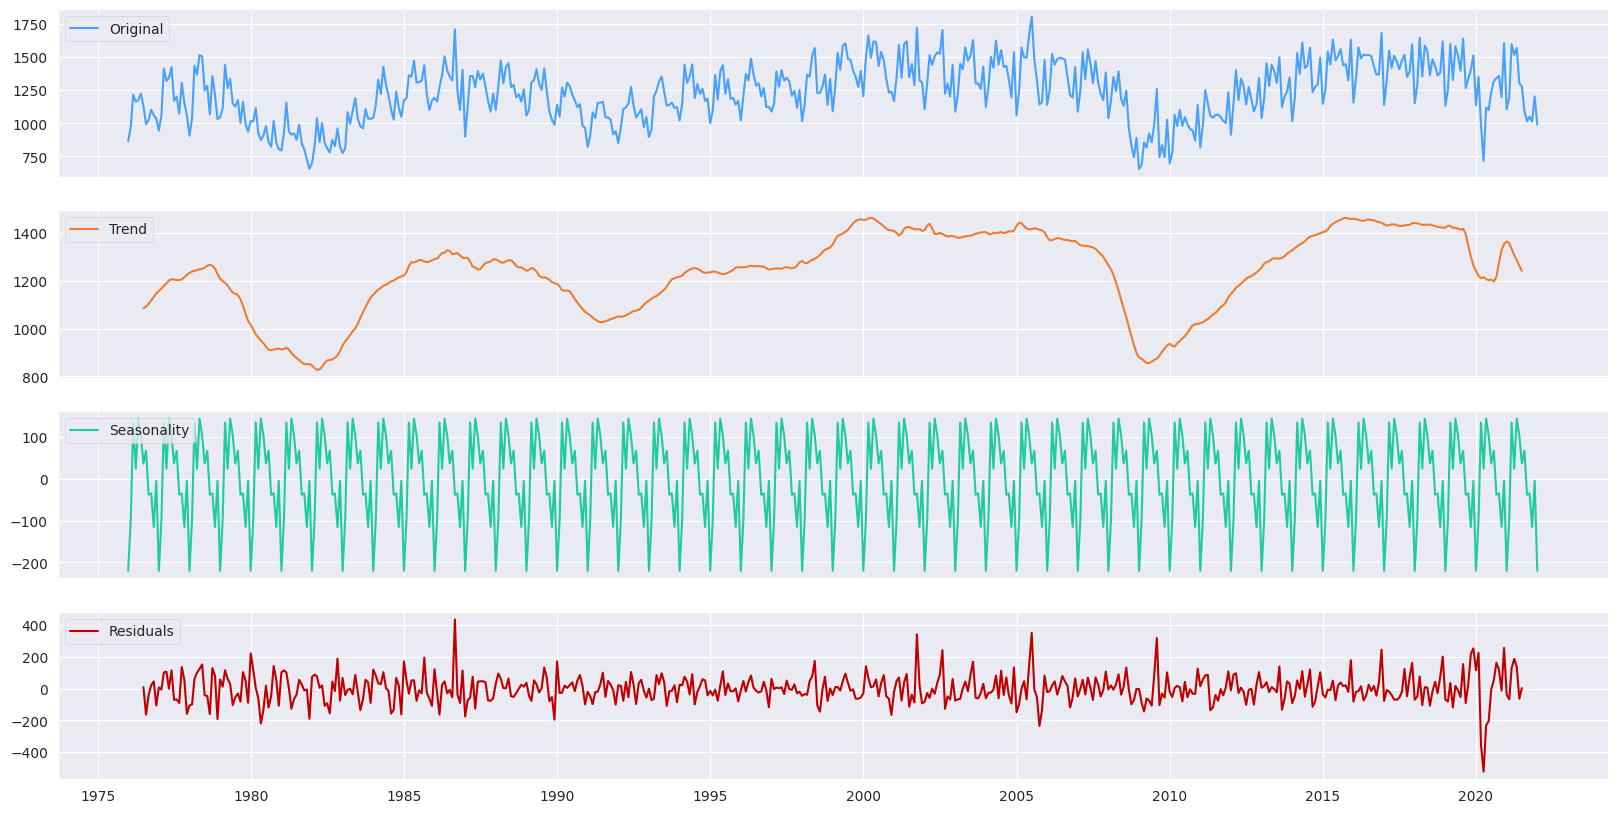

In [105]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(4, 1, sharex = True, sharey = False, figsize = (20,10))

axes[0].plot(sales.Value, label='Original', c="#48A1FA")
axes[0].legend(loc='upper left');

axes[1].plot(trend, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left');

axes[2].plot(seasonal, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left');

axes[3].plot(residual, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left');

**Checking for stationarity**

**Histogram Plot**

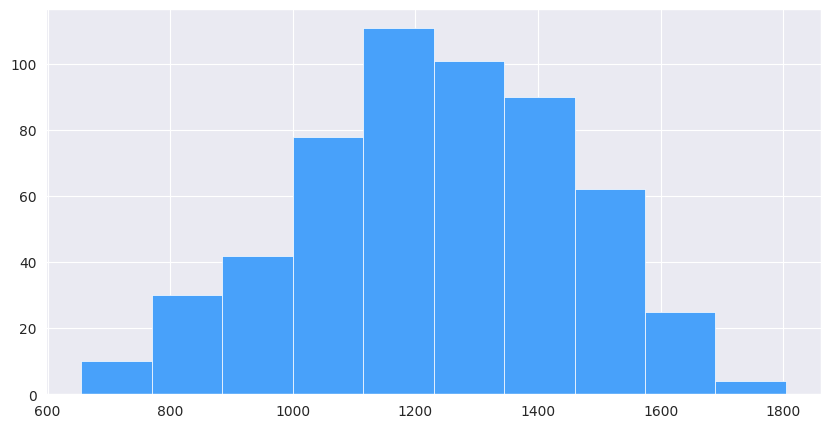

In [106]:
pd.Series(sales['Value']).hist(color="#48A1FA", figsize=(10,5));

**Checking Mean and Variance over small chunks**

In [107]:
sales_chunks = np.split(sales['Value'][:-1], 12)
means = np.round(np.mean(sales_chunks, axis=1), 2)
stds = np.round(np.std(sales_chunks, axis=1), 2)
chunks_df = pd.DataFrame({'chunks': list(range(1, len(sales_chunks)+1)), 'mean_values': means, 'variance_vals': stds})
chunks_df

,chunks,mean_values,variance_vals
0,1,1179.55,159.80
1,2,913.36,117.68
2,3,1244.12,157.88
3,4,1198.75,145.96
4,5,1137.80,135.49
5,6,1269.35,122.10
6,7,1424.70,155.97
7,8,1400.43,165.77
8,9,1097.21,248.69
9,10,1169.00,169.68


**ADF test**

In [108]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, critical_vals, icbest = adfuller(sales['Value'])

In [109]:
print('P value',pval)
print(adf)
print(icbest)
print(usedlag)
print(critical_vals)

P value 0.06222490024371673
-2.773068557093062
6531.654553617461
17
{'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}


**KPSS test**

In [110]:
import pandas as pd
from statsmodels.tsa.stattools import kpss

# Perform the KPSS test
kpss_stat, p_value, lags, critical_values = kpss(sales['Value'])

print("KPSS Statistic:", kpss_stat)
print("p-value:", p_value)
print("Lags:", lags)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

KPSS Statistic: 0.8338589773490158
p-value: 0.01
Lags: 14
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


**Breush Pagan test**

In [111]:
import statsmodels.api as sm
from statsmodels.compat import lzip
const_array = np.ones_like(sales)

reg_model = sm.OLS(sales, const_array).fit()

# Calculate the residuals
residuals = reg_model.resid

bp_model = sm.OLS(residuals**2, const_array).fit()

# Perform the Breusch-Pagan test
bp_test = bp_model.get_robustcov_results(cov_type='HC1')
test_statistic = bp_test.bse[0]
p_value = bp_test.pvalues[0]

print("Breusch-Pagan Test Results:")
print("Test Statistic:", test_statistic)
print("p-value:", p_value)

Breusch-Pagan Test Results:
Test Statistic: 2552.302667089003
p-value: 2.3447502619211134e-61


**All the tests say that time series is non stationary**

**Making Time Series statioanry by making necessary transformations**

In [112]:
sales['difference'] = sales['Value'].diff(12)

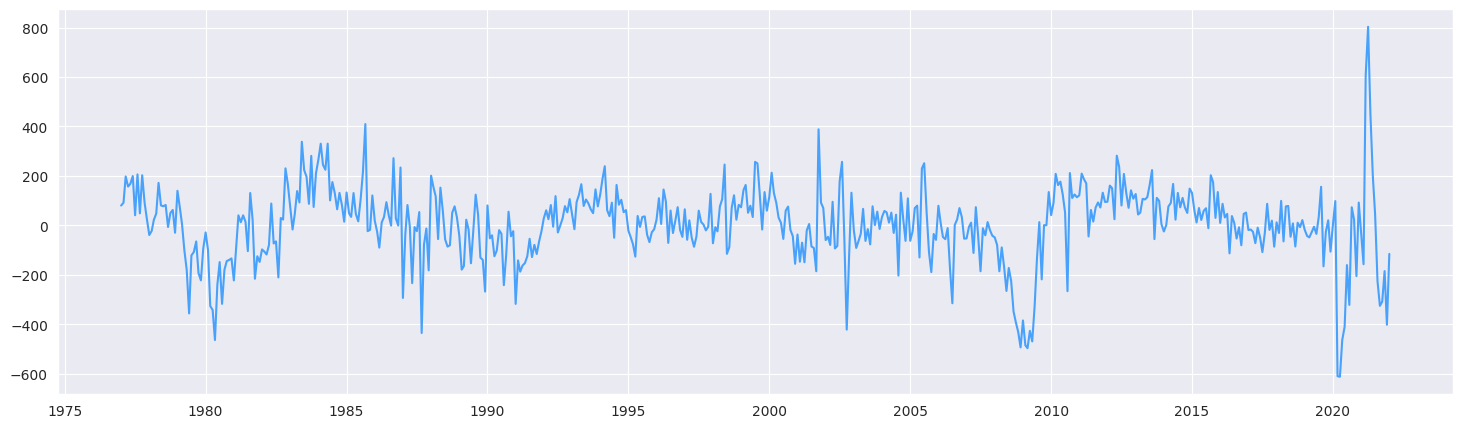

In [113]:
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(sales.difference, c='#48A1FA')
plt.show()

**Making all the values positive to apply log transformation**`

In [114]:
print(min(sales[12:].difference))

-611.916


In [115]:
sales['difference_positive'] = sales['difference'] + 612

In [116]:
sales['log_transformed'] = np.log(sales.difference_positive)

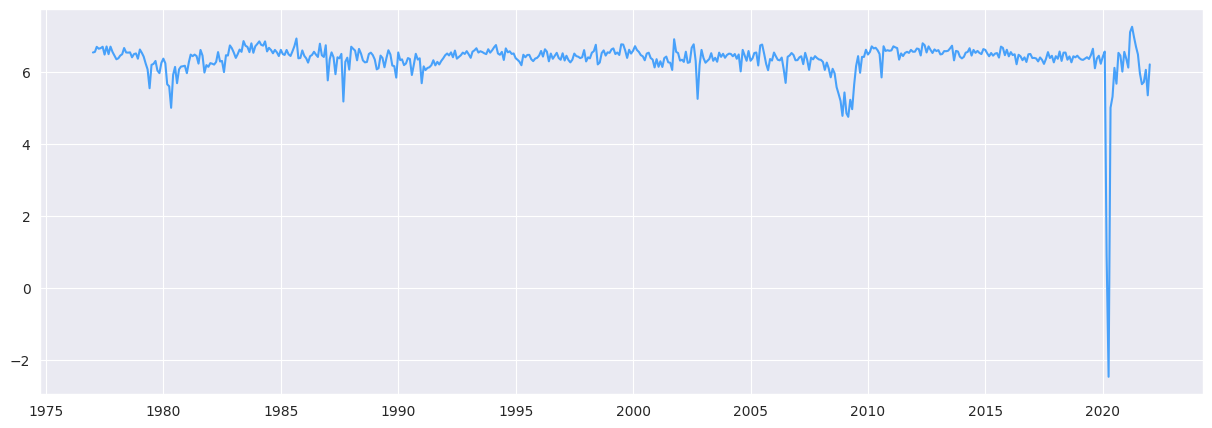

In [117]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sales.log_transformed, c='#48A1FA')
plt.show()

**Now it looks like stationary, let's confirm with ADF, KPSS and Breusch-Pagan Tests**

**ADF test**

In [118]:
adf1, pval1, usedlag1, nobs1, critical_vals1, icbest1 = adfuller(sales['log_transformed'][12:])
print('P value',pval1)
print(adf1)
print(icbest1)
print(usedlag1)
print(critical_vals1)

P value 5.083188612440649e-15
-9.042687965041363
634.8047771734343
2
{'1%': -3.442563336759378, '5%': -2.866927190004947, '10%': -2.5696391843672695}


**KPSS test**

In [119]:
# Perform the KPSS test
kpss_stat1, p_value1, lags1, critical_values1 = kpss(sales['log_transformed'][12:])

# Print the test results
print("KPSS Statistic:", kpss_stat1)
print("p-value:", p_value1)
print("Lags:", lags1)
print("Critical Values:")
for key, value in critical_values1.items():
    print(f"  {key}: {value}")

KPSS Statistic: 0.2063666451772458
p-value: 0.1
Lags: 11
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


In [120]:
const_array1 = np.ones_like(sales.log_transformed[12:])
reg_model1 = sm.OLS(sales.log_transformed[12:], const_array1).fit()

# Calculate the residuals
residuals1 = reg_model1.resid

bp_model1 = sm.OLS(residuals1**2, const_array1).fit()

# Perform the Breusch-Pagan test
bp_test1 = bp_model1.get_robustcov_results(cov_type='HC1')
test_statistic1 = bp_test1.bse[0]
p_value1 = bp_test1.pvalues[0]

# Print the test results
print("Breusch-Pagan Test Results:")
print("Test Statistic:", test_statistic1)
print("p-value:", p_value1)

Breusch-Pagan Test Results:
Test Statistic: 0.1546801885967272
p-value: 0.05921610644039135


In [121]:
from tabulate import tabulate

adf_pvalue = 5.083188612440649e-15
kpss_pvalue = 0.1
bp_pvalue = 0.05921610644039135

data = [
    ['ADF Test', adf_pvalue],
    ['KPSS Test', kpss_pvalue],
    ['Breusch-Pagan Test', bp_pvalue]
]

print(tabulate(data, headers=['Test', 'p-value'], tablefmt='fancy_grid'))


╒════════════════════╤═════════════╕
│ Test               │     p-value │
╞════════════════════╪═════════════╡
│ ADF Test           │ 5.08319e-15 │
├────────────────────┼─────────────┤
│ KPSS Test          │ 0.1         │
├────────────────────┼─────────────┤
│ Breusch-Pagan Test │ 0.0592161   │
╘════════════════════╧═════════════╛


**All tests say that Time series is stationary**

**Decomposing the transformed time series**

In [122]:
ss_decomposition1 = seasonal_decompose(x=sales.log_transformed[12:], model = 'additive', period=12)
trend1 = ss_decomposition1.trend
seasonal1 = ss_decomposition1.seasonal
residual1 = ss_decomposition1.resid

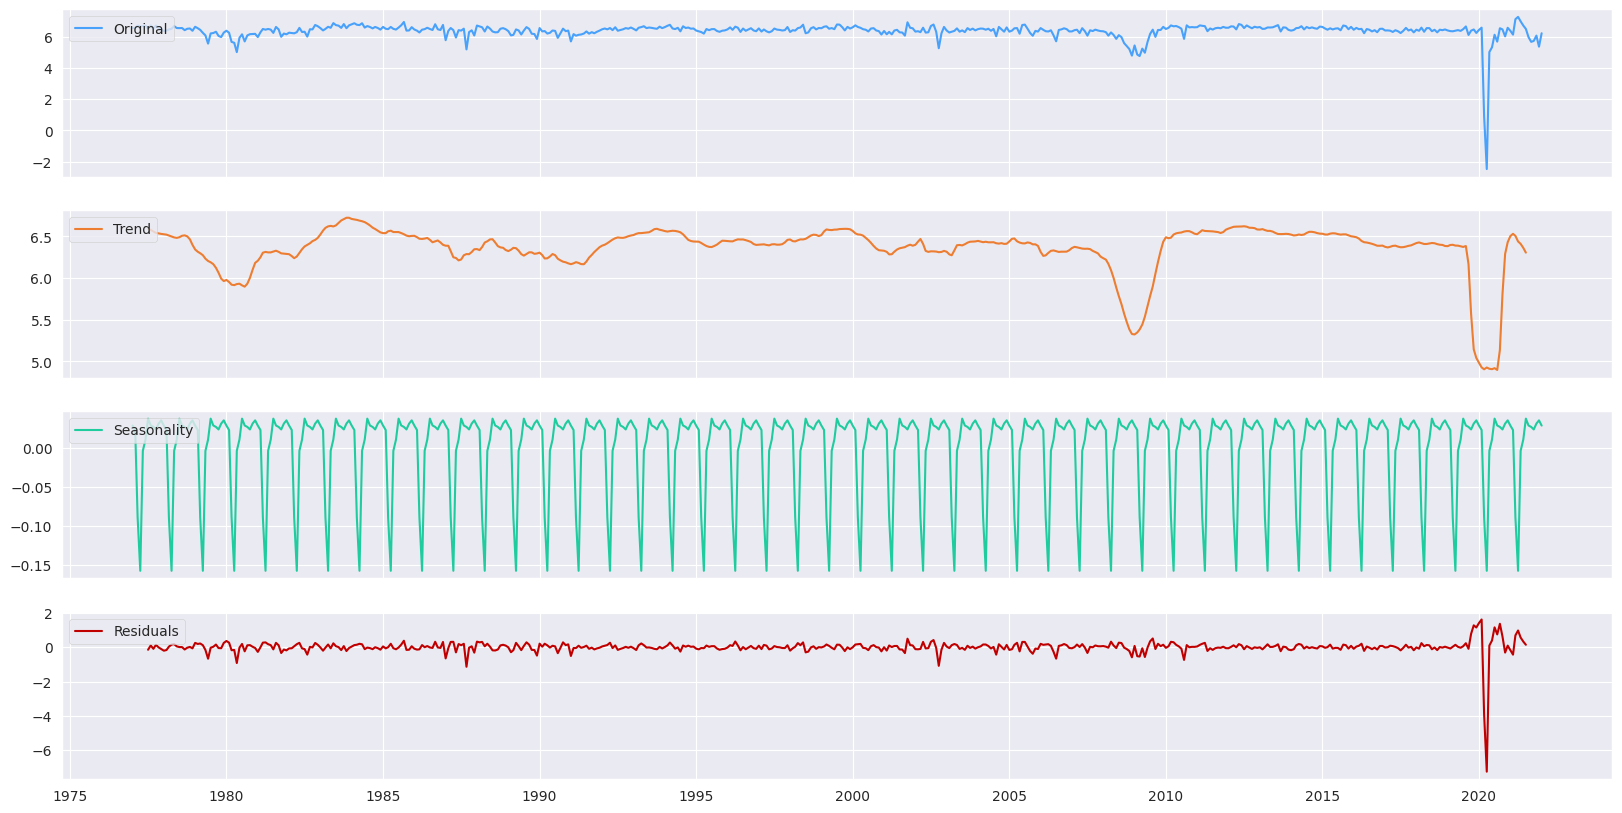

In [123]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20,10))

axes[0].plot(sales.log_transformed[12:], label='Original', c="#48A1FA")
axes[0].legend(loc='upper left');

axes[1].plot(trend1, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left');

axes[2].plot(seasonal1, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left');

axes[3].plot(residual1, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left');

In [124]:
len(sales)
sales

,Value,difference,difference_positive,log_transformed
Date,,,,
1976-01-01,864.600,NaN,NaN,NaN
1976-02-01,973.300,NaN,NaN,NaN
1976-03-01,1216.100,NaN,NaN,NaN
1976-04-01,1163.200,NaN,NaN,NaN
1976-05-01,1176.100,NaN,NaN,NaN
...,...,...,...,...
2021-09-01,1015.935,-325.164,286.836,5.658911
2021-10-01,1051.015,-307.907,304.093,5.717334
2021-11-01,1014.411,-184.726,427.274,6.057425


In [125]:
sales = sales.dropna()

In [126]:
sales

,Value,difference,difference_positive,log_transformed
Date,,,,
1977-01-01,945.000,80.400,692.400,6.540164
1977-02-01,1065.400,92.100,704.100,6.556920
1977-03-01,1414.000,197.900,809.900,6.696911
1977-04-01,1320.300,157.100,769.100,6.645221
1977-05-01,1344.700,168.600,780.600,6.660063
...,...,...,...,...
2021-09-01,1015.935,-325.164,286.836,5.658911
2021-10-01,1051.015,-307.907,304.093,5.717334
2021-11-01,1014.411,-184.726,427.274,6.057425


In [127]:
new_df = sales.reset_index()[['Date', 'log_transformed']].copy()
new_df = new_df.set_index('Date')
train = new_df[:529]
test = new_df[529:]
print(train.shape, test.shape)

(529, 1) (12, 1)


In [128]:
train.head()

,log_transformed
Date,
1977-01-01,6.540164
1977-02-01,6.556920
1977-03-01,6.696911
1977-04-01,6.645221
1977-05-01,6.660063


**Down Scaling the data(range(0, 1))**

In [129]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [130]:
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [131]:
train_scaled[:10]

array([[0.95862784],
       [0.96040927],
       [0.97529196],
       [0.9697967 ],
       [0.97137457],
       [0.97551487],
       [0.95243192],
       [0.97638891],
       [0.95367781],
       [0.97593322]])

In [132]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [133]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

In [134]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [135]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
527/527 - 3s - loss: 0.0723 - 3s/epoch - 5ms/step
Epoch 2/100
527/527 - 1s - loss: 0.0023 - 910ms/epoch - 2ms/step
Epoch 3/100
527/527 - 1s - loss: 0.0023 - 919ms/epoch - 2ms/step
Epoch 4/100
527/527 - 1s - loss: 0.0024 - 894ms/epoch - 2ms/step
Epoch 5/100
527/527 - 1s - loss: 0.0024 - 903ms/epoch - 2ms/step
Epoch 6/100
527/527 - 1s - loss: 0.0024 - 895ms/epoch - 2ms/step
Epoch 7/100
527/527 - 1s - loss: 0.0024 - 935ms/epoch - 2ms/step
Epoch 8/100
527/527 - 1s - loss: 0.0024 - 877ms/epoch - 2ms/step
Epoch 9/100
527/527 - 1s - loss: 0.0025 - 1s/epoch - 2ms/step
Epoch 10/100
527/527 - 1s - loss: 0.0024 - 1s/epoch - 2ms/step
Epoch 11/100
527/527 - 1s - loss: 0.0024 - 1s/epoch - 3ms/step
Epoch 12/100
527/527 - 1s - loss: 0.0023 - 1s/epoch - 2ms/step
Epoch 13/100
527/527 - 1s - loss: 0.0024 - 890ms/epoch - 2ms/step
Epoch 14/100
527/527 - 1s - loss: 0.0024 - 860ms/epoch - 2ms/step
Epoch 15/100
527/527 - 1s - loss: 0.0024 - 889ms/epoch - 2ms/step
Epoch 16/100
527/527 - 1s - loss: 

In [136]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 22ms/step
Train Score: 0.44 RMSE
Test Score: 0.48 RMSE


In [139]:
# Reshape train and test predictions
trainPredict = trainPredict.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)

In [140]:
# Apply inverse transformations
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY).reshape(-1, 1)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY).reshape(-1, 1)

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % trainScore)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % testScore)

Train Score: 4.11 RMSE
Test Score: 4.49 RMSE


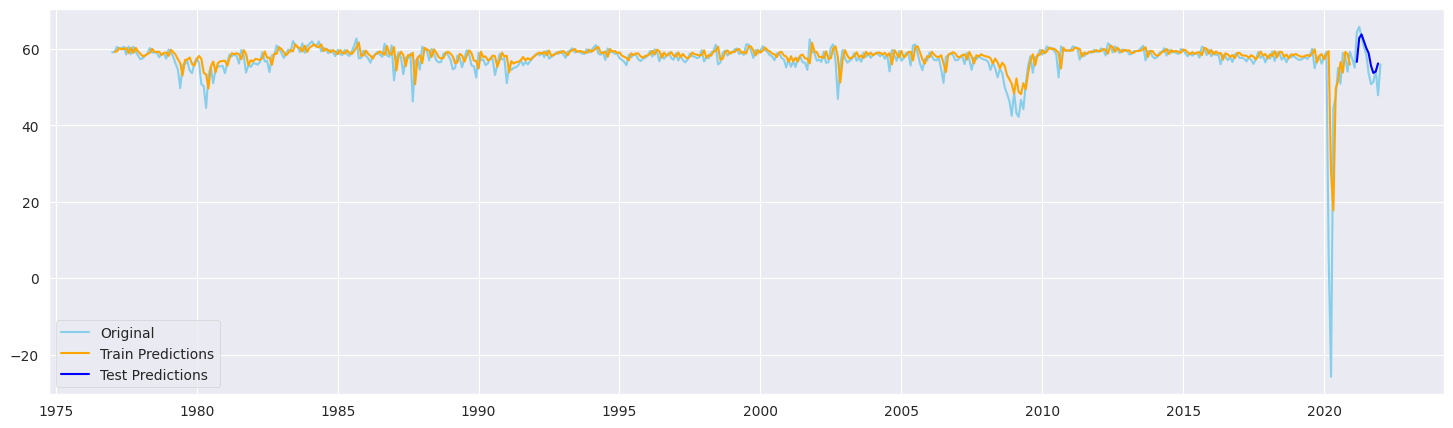

In [150]:
# Create empty arrays for plotting
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(new_df)-1, :] = testPredict

# Plot original data and predictions
fig, ax = plt.subplots(figsize=(18,5))
plt.plot(new_df.index, scaler.inverse_transform(new_df), label='Original', color='skyblue')
plt.plot(new_df.index, trainPredictPlot, label='Train Predictions', color='orange')
plt.plot(new_df.index, testPredictPlot, label='Test Predictions', color='blue')
plt.legend()
plt.show()